In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset = MNIST(root='./data', download=True)

In [3]:
len(dataset)

60000

In [4]:
test_dataset = MNIST(root='./data', train=False)

In [5]:
len(test_dataset)

10000

In [6]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

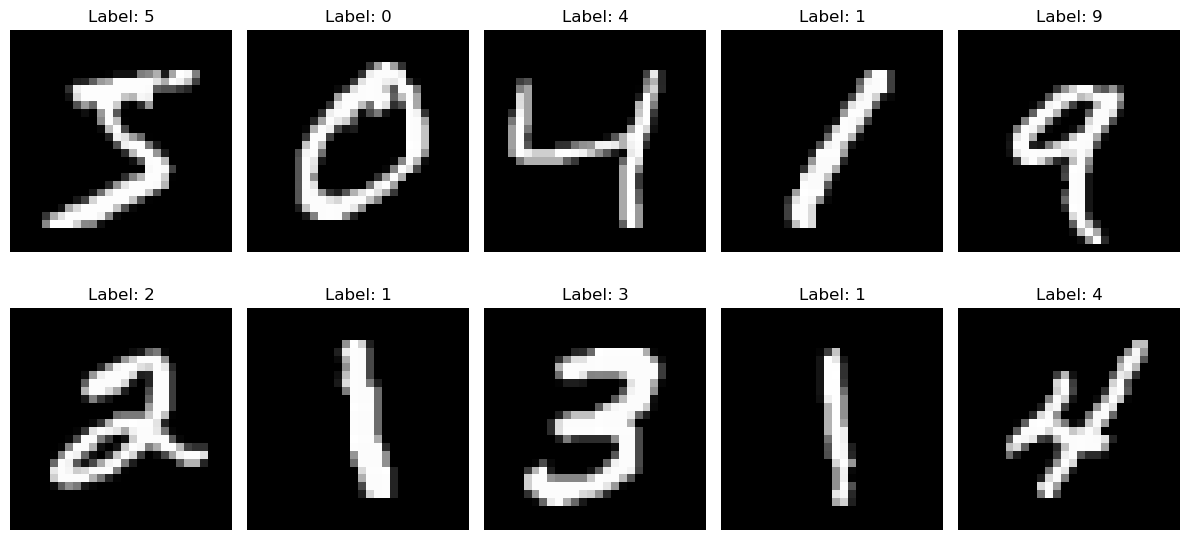

In [7]:
plt.figure(figsize=(12, 6))
for i in range(10):
    image, label = dataset[i]
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
plt.tight_layout()
plt.show()

In [8]:
dataset = MNIST(root='./data', train=True, transform=transforms.ToTensor())

In [9]:
img_tensor, label = dataset[0]
img_tensor.shape, label

(torch.Size([1, 28, 28]), 5)

In [10]:
print(img_tensor[0, 10:15, 10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


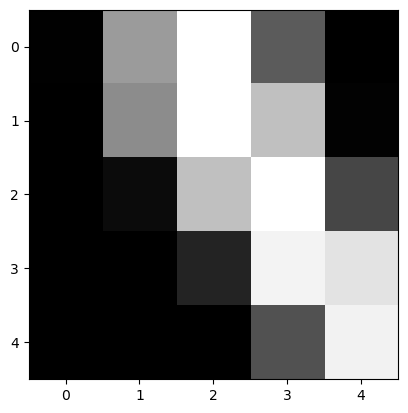

In [11]:
plt.imshow(img_tensor[0, 10:15, 10:15], cmap='gray')

In [12]:
train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [13]:
batch_size = 128

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [14]:
input_size = 28*28
num_classes = 10

model = nn.Linear(input_size, num_classes)

In [15]:
print(model.weight.shape)
print(model.bias.shape)

torch.Size([10, 784])
torch.Size([10])


In [16]:
for images, labels in train_loader:
    print(labels)
    print(images.shape, labels.shape)
    outputs = model(images.reshape(images.shape[0], -1))
    print(outputs.shape)
    print(outputs[0])
    break

tensor([1, 8, 1, 7, 3, 0, 5, 1, 7, 9, 1, 9, 7, 8, 5, 9, 9, 6, 7, 0, 3, 7, 4, 1,
        5, 3, 7, 1, 4, 7, 1, 4, 9, 4, 4, 3, 7, 3, 2, 7, 7, 3, 5, 2, 0, 6, 7, 0,
        2, 1, 6, 4, 8, 9, 7, 6, 2, 0, 5, 9, 1, 3, 9, 1, 5, 5, 4, 2, 4, 3, 5, 6,
        8, 6, 2, 3, 2, 0, 9, 8, 8, 1, 8, 8, 0, 6, 0, 3, 1, 8, 4, 1, 2, 4, 0, 6,
        8, 2, 8, 1, 6, 2, 5, 8, 9, 3, 4, 4, 8, 1, 7, 1, 7, 6, 6, 4, 6, 9, 0, 5,
        3, 3, 5, 2, 7, 9, 3, 6])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 10])
tensor([ 0.1118,  0.3069,  0.1262, -0.1521,  0.1801,  0.0260,  0.1531,  0.0167,
        -0.0187,  0.0414], grad_fn=<SelectBackward0>)


In [17]:
images.shape

torch.Size([128, 1, 28, 28])

In [30]:
class MNISTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        return self.fc(x)
    
    def training_step(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        return {'loss': loss}
    
    def validation_step(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print(f'Epoch [{epoch}], val_loss: {result["val_loss"]:.4f}, val_acc: {result["val_acc"]:.4f}')
    

model = MNISTModel()

In [31]:
model.fc

Linear(in_features=784, out_features=10, bias=True)

In [20]:
print(model.fc.weight.shape, model.fc.bias.shape)

torch.Size([10, 784]) torch.Size([10])


In [21]:
list(model.parameters())

[Parameter containing:
 tensor([[-2.2556e-02,  6.4441e-03,  1.9656e-02,  ...,  5.0599e-03,
          -1.3133e-02,  1.6053e-02],
         [ 6.7110e-03,  1.7538e-02,  1.2750e-02,  ...,  1.0366e-02,
          -2.8383e-02,  3.0054e-02],
         [-4.7211e-05, -3.4434e-03, -3.5003e-02,  ..., -1.5922e-02,
           1.1142e-02, -2.6285e-02],
         ...,
         [ 3.0061e-02,  2.7432e-04,  3.3322e-02,  ..., -3.1518e-02,
           1.3900e-02,  7.0929e-03],
         [ 2.9686e-02, -1.7194e-02, -6.3406e-03,  ..., -3.0602e-02,
          -3.0556e-02, -2.3751e-02],
         [-3.2713e-02,  3.1409e-02,  3.5567e-02,  ..., -1.4705e-02,
          -3.1804e-02,  2.8948e-03]], requires_grad=True),
 Parameter containing:
 tensor([-0.0224, -0.0073,  0.0099,  0.0309,  0.0244,  0.0029,  0.0337, -0.0043,
         -0.0329,  0.0091], requires_grad=True)]

In [22]:
for images, labels in train_loader:
    outputs = model(images)
    break

print(f'Output shape: {outputs.shape}')
print(f'Sample output: {outputs[:2].data}')

Output shape: torch.Size([128, 10])
Sample output: tensor([[-0.1194, -0.0276, -0.2134, -0.0986,  0.1334, -0.0613,  0.1712, -0.0351,
          0.0270,  0.0712],
        [-0.2397,  0.0838,  0.0137,  0.1495,  0.0944, -0.0674,  0.2437,  0.1000,
          0.0881, -0.1472]])


In [23]:
probs = F.softmax(outputs, dim=1)
print(f'Probabilities shape: {probs.shape}')
print(f'Sample probabilities: {probs[:2].data}')

Probabilities shape: torch.Size([128, 10])
Sample probabilities: tensor([[0.0895, 0.0982, 0.0815, 0.0914, 0.1153, 0.0949, 0.1197, 0.0974, 0.1037,
         0.1083],
        [0.0755, 0.1044, 0.0973, 0.1114, 0.1055, 0.0897, 0.1225, 0.1061, 0.1048,
         0.0828]])


In [24]:
max_probs, preds = torch.max(probs, dim=1)
print(f'Max probabilities shape: {max_probs.shape}')
print(f'Predictions shape: {preds.shape}')
print(max_probs)
print(preds)

Max probabilities shape: torch.Size([128])
Predictions shape: torch.Size([128])
tensor([0.1197, 0.1225, 0.1440, 0.1403, 0.1439, 0.1200, 0.1561, 0.1280, 0.1304,
        0.1638, 0.1198, 0.1186, 0.1491, 0.1563, 0.1313, 0.1568, 0.1288, 0.1296,
        0.1266, 0.1387, 0.1344, 0.1335, 0.1483, 0.1282, 0.1405, 0.1247, 0.1317,
        0.1453, 0.1624, 0.1357, 0.1198, 0.1470, 0.1281, 0.1526, 0.1371, 0.1194,
        0.1162, 0.1399, 0.1206, 0.1311, 0.1366, 0.1490, 0.1382, 0.1218, 0.1445,
        0.1314, 0.1312, 0.1259, 0.1292, 0.1220, 0.1177, 0.1459, 0.1420, 0.1402,
        0.1362, 0.1361, 0.1633, 0.1341, 0.1483, 0.1191, 0.1502, 0.1391, 0.1644,
        0.1269, 0.1147, 0.1307, 0.1443, 0.1231, 0.1129, 0.1401, 0.1443, 0.1441,
        0.1235, 0.1344, 0.1541, 0.1408, 0.1203, 0.1098, 0.1465, 0.1475, 0.1268,
        0.1263, 0.1578, 0.1432, 0.1565, 0.1436, 0.1241, 0.1274, 0.1279, 0.1519,
        0.1482, 0.1465, 0.1377, 0.1388, 0.1493, 0.1200, 0.1170, 0.1317, 0.1298,
        0.1380, 0.1445, 0.1191, 0.1143, 

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    correct = (preds == labels).sum().item()
    return correct / len(preds)

In [26]:
accuracy(outputs, labels)

0.0703125

In [27]:
loss_fn = F.cross_entropy

In [28]:
loss = loss_fn(outputs, labels)
print(f'Loss: {loss.item()}')

Loss: 2.3331665992736816


In [32]:
opt_func = optim.SGD

In [34]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [44]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=opt_func):
    optimizer = opt_func(model.parameters(), lr)
    history = []
    
    for epoch in range(epochs):
        for batch in train_loader:
            loss_dict = model.training_step(batch)
            loss = loss_dict['loss']  # Extract the loss tensor from the dictionary
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [39]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.3126845359802246, 'val_acc': 0.11867088824510574}

In [45]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9406, val_acc: 0.6253
Epoch [1], val_loss: 1.6715, val_acc: 0.7323
Epoch [2], val_loss: 1.4717, val_acc: 0.7646
Epoch [3], val_loss: 1.3212, val_acc: 0.7811
Epoch [4], val_loss: 1.2057, val_acc: 0.7921


In [46]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1151, val_acc: 0.8012
Epoch [1], val_loss: 1.0426, val_acc: 0.8083
Epoch [1], val_loss: 1.0426, val_acc: 0.8083
Epoch [2], val_loss: 0.9833, val_acc: 0.8147
Epoch [2], val_loss: 0.9833, val_acc: 0.8147
Epoch [3], val_loss: 0.9341, val_acc: 0.8191
Epoch [3], val_loss: 0.9341, val_acc: 0.8191
Epoch [4], val_loss: 0.8926, val_acc: 0.8234
Epoch [4], val_loss: 0.8926, val_acc: 0.8234


In [47]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8570, val_acc: 0.8269
Epoch [1], val_loss: 0.8262, val_acc: 0.8296
Epoch [1], val_loss: 0.8262, val_acc: 0.8296
Epoch [2], val_loss: 0.7993, val_acc: 0.8318
Epoch [2], val_loss: 0.7993, val_acc: 0.8318
Epoch [3], val_loss: 0.7755, val_acc: 0.8327
Epoch [3], val_loss: 0.7755, val_acc: 0.8327
Epoch [4], val_loss: 0.7544, val_acc: 0.8350
Epoch [4], val_loss: 0.7544, val_acc: 0.8350


In [48]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7354, val_acc: 0.8379
Epoch [1], val_loss: 0.7183, val_acc: 0.8392
Epoch [1], val_loss: 0.7183, val_acc: 0.8392
Epoch [2], val_loss: 0.7028, val_acc: 0.8408
Epoch [2], val_loss: 0.7028, val_acc: 0.8408
Epoch [3], val_loss: 0.6886, val_acc: 0.8428
Epoch [3], val_loss: 0.6886, val_acc: 0.8428
Epoch [4], val_loss: 0.6756, val_acc: 0.8443
Epoch [4], val_loss: 0.6756, val_acc: 0.8443


In [50]:
history5 = fit(5, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 0.5870, val_acc: 0.8570
Epoch [1], val_loss: 0.5371, val_acc: 0.8624
Epoch [1], val_loss: 0.5371, val_acc: 0.8624
Epoch [2], val_loss: 0.5040, val_acc: 0.8675
Epoch [2], val_loss: 0.5040, val_acc: 0.8675
Epoch [3], val_loss: 0.4805, val_acc: 0.8714
Epoch [3], val_loss: 0.4805, val_acc: 0.8714
Epoch [4], val_loss: 0.4626, val_acc: 0.8755
Epoch [4], val_loss: 0.4626, val_acc: 0.8755


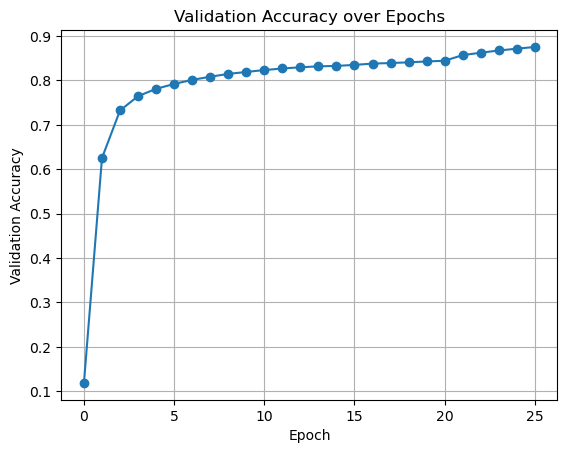

In [51]:
history = [result0] + history1 + history2 + history3 + history4 + history5
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-o')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.grid()
plt.show()

In [ ]:
test_dataset = MNIST(root='./data', train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False) 

In [53]:
def predict_image(img, model):
    xb = img.unsqueeze(0)  
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7, Predicted: 7
Label: 2, Predicted: 2
Label: 1, Predicted: 1
Label: 0, Predicted: 0
Label: 4, Predicted: 4
Label: 1, Predicted: 1
Label: 4, Predicted: 4
Label: 9, Predicted: 9
Label: 5, Predicted: 6
Label: 9, Predicted: 9


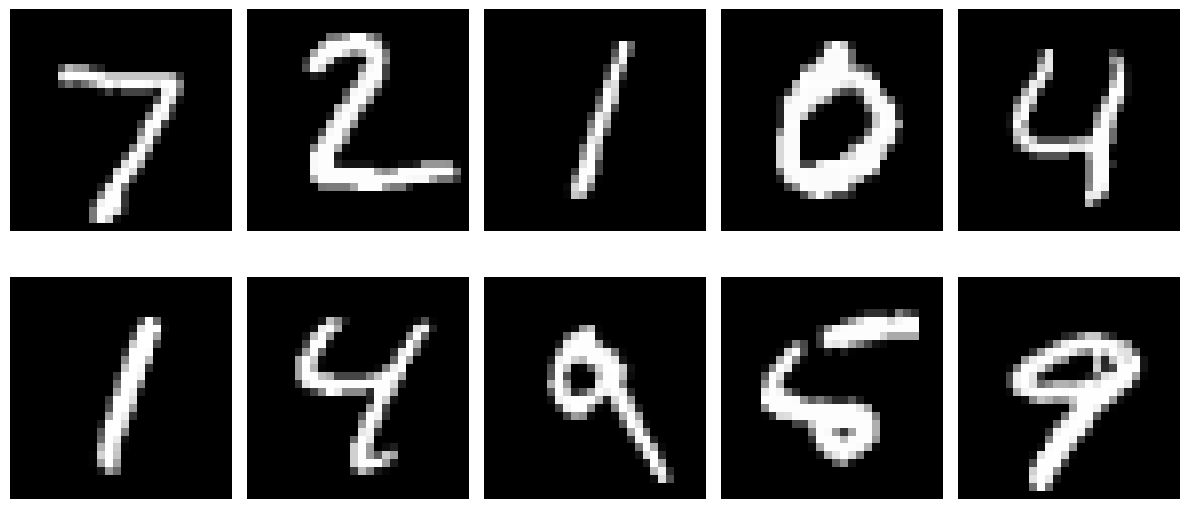

In [59]:
plt.figure(figsize=(12, 6))
for i in range(10):
    img, label = test_dataset[i]
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.imshow(img[0], cmap='gray')
    print(f'Label: {label}, Predicted: {predict_image(img, model)}')
plt.tight_layout()
plt.show()

In [60]:
result = evaluate(model, test_loader)
result

{'val_loss': 0.4284059405326843, 'val_acc': 0.8899327516555786}

In [61]:
torch.save(model.state_dict(), 'mnist_model.pth')
print('Model saved to mnist_model.pth')

Model saved to mnist_model.pth


In [62]:
model.state_dict()

OrderedDict([('fc.weight',
              tensor([[ 0.0081,  0.0158, -0.0215,  ..., -0.0023, -0.0324, -0.0051],
                      [ 0.0041,  0.0302, -0.0145,  ...,  0.0333,  0.0019, -0.0286],
                      [-0.0311,  0.0032,  0.0064,  ..., -0.0249,  0.0264, -0.0266],
                      ...,
                      [ 0.0238,  0.0263,  0.0041,  ..., -0.0090, -0.0172,  0.0224],
                      [ 0.0288, -0.0015, -0.0115,  ...,  0.0015, -0.0112,  0.0230],
                      [ 0.0147, -0.0217,  0.0287,  ..., -0.0025,  0.0041, -0.0048]])),
             ('fc.bias',
              tensor([-0.0596,  0.1493, -0.0091, -0.0626,  0.0423,  0.1156,  0.0135,  0.0796,
                      -0.2534, -0.0190]))])

In [64]:
model2 = MNISTModel()
model2.load_state_dict(torch.load('mnist_model.pth'))
model2.state_dict()

OrderedDict([('fc.weight',
              tensor([[ 0.0081,  0.0158, -0.0215,  ..., -0.0023, -0.0324, -0.0051],
                      [ 0.0041,  0.0302, -0.0145,  ...,  0.0333,  0.0019, -0.0286],
                      [-0.0311,  0.0032,  0.0064,  ..., -0.0249,  0.0264, -0.0266],
                      ...,
                      [ 0.0238,  0.0263,  0.0041,  ..., -0.0090, -0.0172,  0.0224],
                      [ 0.0288, -0.0015, -0.0115,  ...,  0.0015, -0.0112,  0.0230],
                      [ 0.0147, -0.0217,  0.0287,  ..., -0.0025,  0.0041, -0.0048]])),
             ('fc.bias',
              tensor([-0.0596,  0.1493, -0.0091, -0.0626,  0.0423,  0.1156,  0.0135,  0.0796,
                      -0.2534, -0.0190]))])